In [1]:
from tictoc import tic, toc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from BCS_casadi import BCS_model
from plot_result import PlotResult
from bcs_envelope import BcsEnvelope
from nmpc_class import NMPC
import seaborn as sns
#sns.set_theme()




# steady-state conditions
xss = np.vstack([8311024.82175957, 2990109.06207437,
                0.00995042241351780, 50., 50.])
nx = 5
nu = 2
ny = 2

uss = np.vstack([50., 50.])
yss = np.vstack([6000142.88550200, 592.126490003812])
#output scale factor


# Controller parameters
Hp = 10  # prediction horizon
Hc = 2  # control horizon
Ts = 2  # sampling time
# --------------------------------------------------------------------------
# constraints on inputs
# --------------------------------------------------------------------------
umin = np.vstack([35, 0])    # lower bounds of inputs
umax = np.vstack([65, 100])    # upper bounds of inputs
# maximum variation of input moves: [0.5 Hz/s; 0.5 #/s]
dumax = Ts*np.vstack([0.5, 0.5])
# ----------------------------------------------
# ------Normalização através dos pesos----------
q = np.hstack([100, 1]) / (yss**2)  # weights on controlled variables
q = np.hstack([1e6, 1e8]) / (yss**2)  # weights on controlled variables
r = np.array([100, 1]) / (uss.T**2)  # weights on control actions

qu = 1000 / (uss[1]**2)

print("Instancia BCS")
bcs_init = [nu, nx, ny, Ts, umin, umax, dumax]
nmpc = NMPC(Hp, Hc, q, r, qu, bcs_init)
bcs = nmpc.bcs
def shift_du(Du):
    return np.vstack([Du[bcs.nu:],Du[-bcs.nu:]])

# --------------------------------------------------------------------------
# Initial condition (preferred steady-state)
# --------------------------------------------------------------------------
uk_1 = np.vstack([50., 50.])  # manipulated variable
print("Initial states")
print("Pbh, Pwh, q, df, dzc")
x0 = np.vstack([8311024.82175957, 2990109.06207437,
               0.00995042241351780, 50., 50.])  # state variables
print("Initial control")
print("f, zc")

try:
    print(bcs.desnorm_x(bcs.F(x0=bcs.norm_x(x0), p=uss)['xf']))
except Exception as e:
  print("An exception was raised here:")
  print(e)

  


utg = 60   # target na choke
pm = 2e6   # pressão da manifold
# ymax[0,0] = yss[0]; # Pressao de intake
# Regiao de operação
hlim = bcs.envelope.Hlim(x0[2]*3600)
ymin = np.vstack([yss[0], min(hlim)])  # Pressao de intake e  Downtrhust
ymax = np.vstack([xss[0], max(hlim)])  # Pressao de intake e  Uptrhust
# ymin(2,1) = min(hlim); # Downtrhust
# ymax(2,1) = max(hlim); # Uptrhust
xpk = xss
ysp = yss
Vruido = ((0.01/3)*np.diag(yss[:, 0]))**2
Du = np.zeros((nmpc.Hc*bcs.nu, 1))
# # Parameters: initial states, du,utg, u0,ysp
P = np.vstack([x0, uk_1, Du, utg])

Yk = yss
Xk = xss.reshape((xss.shape[0], 1))
Ysp = yss
HLim = np.vstack([ymax[1], ymin[1]])
PINLim = np.vstack([ymax[0], ymin[0]])
# Simulation Loop -------------------------------- ------------------------------
tsim = 2.    # minutes
nsim = int(60*tsim/Ts)   # number of steps
uk = np.zeros((bcs.nu, int(nsim)))
rows = []

try:
    Du, ysp, sol = nmpc.nmpc_solver(P,ysp, [ymin, ymax])
    print("Limites Saída: ",ymin)
    print("Limites Saída: ",ymax)
    
except RuntimeError:         # Catch error - infeasibilities
    print("Erro no solver - Normalizar todos os estados inclusive dz/dt e df/dt")
    #nmpc.opti.debug.show_infeasibilities()
    raise RuntimeError
print(Du)
print(Du[:bcs.nu, :])
print(bcs.integrator_ode(x0, uk_1))
print("Parâmetros")
print(P.T)
uk_1 += Du[:nmpc.Hc, :]
Du=shift_du(Du)
print(uk_1)
x0=bcs.integrator_ode(x0, uk_1)
print(bcs.integrator_ode(x0, uk_1))
print(bcs.eq_medicao(x0))
P = np.vstack([x0, uk_1, Du, utg])
print("Parâmetros")
print(P.T)
print(ymin,ymax)
# try:
#     Du, ysp, sol = nmpc.nmpc_solver(P, ysp,[ymin, ymax])
# except RuntimeError:         # Catch error - infeasibilities
#     print("Erro no solver - Normalizar todos os estados inclusive dz/dt e df/dt")
#     #nmpc.opti.debug.show_infeasibilities()
#     raise RuntimeError

Dados carregados
Instancia BCS
Initial states
Pbh, Pwh, q, df, dzc
Initial control
f, zc
[8.31102e+06, 2.99011e+06, 0.00995042, 50, 50]
controle:  [[50. 50.]]
Estados:  [[8.31102482e+06 2.99010906e+06 9.95042241e-03 5.00000000e+01
  5.00000000e+01]]
Saídas:  [[6.00014289e+06 5.92126490e+02]]
Estados preditos:  [[8.31102e+06, 2.99011e+06, 0.00995042, 50, 50]]
Limites Saída:  [[6.00014289e+06 4.22399096e+02]]
Limites Saída:  [[8.31102482e+06 1.07150269e+03]]

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number o

In [2]:
xt = np.vstack([8311024.82175957, 2990109.06207437,
               0.00995042241351780, 50., 50.]) 
try:
    x=bcs.desnorm_x(bcs.F(x0=bcs.norm_x(xt),p=uss)['xf'])
except Exception as e:
    print("Erro no integrador 1")
    print(x)
    print(e)

In [3]:
hlim = bcs.envelope.Hlim(9.95041674e-03*3600)
hlim

[array([422.39861446]), array([1071.50280029])]

In [5]:
9.95041674e-03*3600

35.821500264

(<Figure size 800x800 with 1 Axes>,
 <AxesSubplot:xlabel='$q_p (m^3/h)$', ylabel='H (m)'>)

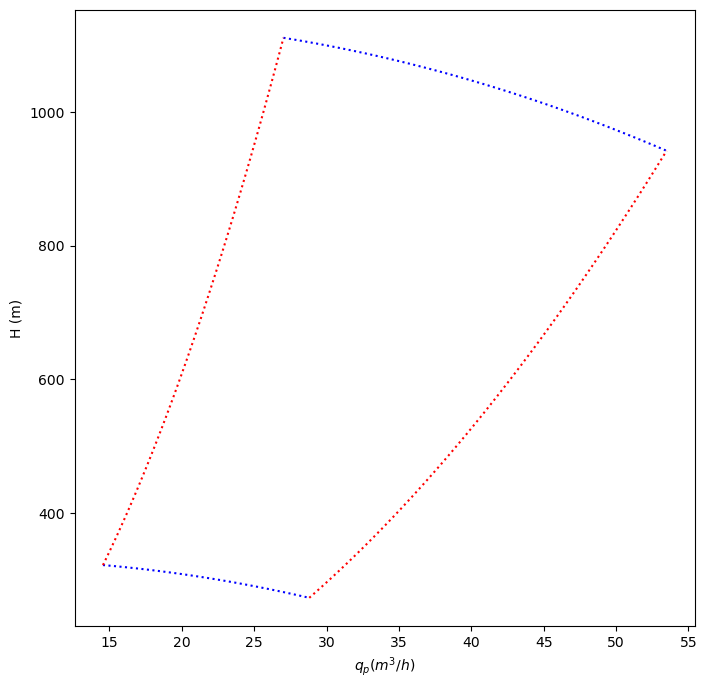

In [4]:
bcs.envelope.grafico_envelope2()

In [5]:
# Initialize list
Lst = [50, 70, 30, 20, 90, 10, 50]
 
# Display list
print(Lst[0::2])

[50, 30, 90, 50]
